In [24]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [25]:
import pathlib

# This file contains all the main external libs we'll use
from fastai.imports import *

In [26]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [27]:
PATH = pathlib.Path.home() / 'data/planet-amazon'
image_size = 64
batch_size = 64

In [38]:
def f2(preds, targs, start=0.17, end=0.24, step=0.01):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return max([fbeta_score(targs, (preds>th), 2, average='samples')
                    for th in np.arange(start,end,step)])
    
metrics = [f2]

In [52]:
# choose arch
# resnet34 -> resnext50 -> resnext101_64
arch = resnext50

def get_data(image_size, batch_size=64):
    # configure transforms
    tfms = tfms_from_model(arch, image_size, aug_tfms=transforms_top_down, max_zoom=1.05)

    # create the image classifier data source
    # base directory is PATH, training labels are contained in the CSV
    return  ImageClassifierData.from_csv(
        PATH, 'train-jpg', str(PATH / 'train_v2.csv'), 
        tfms=tfms,
        suffix='.jpg', test_name='test-jpg',
        bs=batch_size, num_workers=4
    )
    

data = get_data(image_size, batch_size)
data = data.resize(int(image_size * 1.3), 'tmp')

# create our learner
learn = ConvLearner.pretrained(arch, data, precompute=True, metrics=metrics)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 22%|██▏       | 112/506 [00:05<00:18, 21.20it/s, loss=0.816]

Exception in thread Thread-52:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   f2                          
    0      0.242077   0.288747   0.831598  



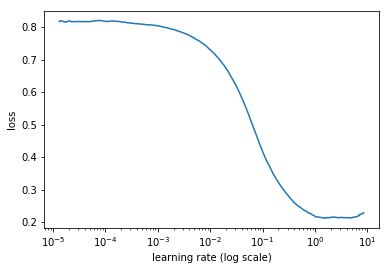

In [53]:
# find our optimal learning rate
lrf = learn.lr_find()
learn.sched.plot()

In [54]:
lr = .2

# train for 2 epochs
learn.fit(lr, 2, cycle_len=1)

# train for more epochs
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   f2                          
    0      0.146626   0.136769   0.877948  
    1      0.138449   0.131288   0.883946                    



HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                          
    0      0.134624   0.12872    0.886817  
    1      0.132382   0.128013   0.88627                     
    2      0.12197    0.12551    0.889967                    
    3      0.127513   0.126739   0.887715                    
    4      0.124616   0.124833   0.891371                    
    5      0.120236   0.123139   0.892588                    
    6      0.114194   0.122982   0.892463                    



[0.122982025, 0.8924628587132141]

In [55]:
# stop using the pre-computed samples and switch to data augmentation
learn.precompute = False

# train with differential learning rates
lrs = [lr/9, lr/3, lr]
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

learn.save(f'{image_size}')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                          
    0      0.130565   0.12437    0.889347  
    1      0.134828   0.123519   0.892084                    
    2      0.131363   0.122995   0.892394                    
    3      0.13295    0.123954   0.89146                     
    4      0.132895   0.122796   0.890394                    
    5      0.130297   0.121798   0.893291                    
    6      0.126109   0.121469   0.893656                    



[0.12146861, 0.8936555871764352]

In [57]:
image_size = 128

learn.set_data(get_data(image_size))
learn.freeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

learn.save(f'{image_size}')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                          
    0      0.120409   0.112296   0.904943  
    1      0.117983   0.110239   0.905928                    
    2      0.114745   0.10934    0.907494                    
    3      0.116605   0.109936   0.907707                    
    4      0.114048   0.107608   0.908794                    
    5      0.113233   0.107318   0.909051                    
    6      0.109989   0.106796   0.910021                    



HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                           
    0      0.101325   0.090778   0.925487  
    1      0.096471   0.088492   0.927125                     
    2      0.089065   0.085522   0.930065                     
 22%|██▏       | 110/506 [00:16<00:57,  6.86it/s, loss=0.0918]

KeyboardInterrupt: 

In [ ]:
image_size = 256

learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

learn.save(f'{image_size}')

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.387388   0.245343   0.923372  
    1      0.340651   0.236304   0.924808                    


In [ ]:
# in both of the last 2 training rounds, we observed train_loss > val_loss
# this indicated underfitting, where the model isn't able to full learn sufficiently
# from an individual cycle.  so we set the cycle_mult to continually increase the
# cosign annealling schedule.  at the end, we see the train_loss == val_loss.
# 
# train for 3 more cycles, doubling cycle length, restarting every cycle
learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2)

In [ ]:
# save our model
learn.save('299_all_50')

In [ ]:
# load our model back
learn.load('299_all_50')

In [ ]:
# unfreeze the other layers (but not the batch-norm ones)
# train differential learning rates for different layers
# for 3 restarts with increasing cycle len
learn.unfreeze()
learn.bn_freeze(True)

# find our new optimal learning rate
lrf = learn.lr_find()
learn.sched.plot()

In [ ]:
# train till overfit.
#
# but since this data is actually sampled from imagenet, we don't observe any 
# improvement from additional cycles.  but throwing some in for good measure.
lr = np.array([1e-7, 1e-6, 1e-5])
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

In [ ]:
# test-time augmentation predictions
log_preds, y = learn.TTA()

# compute probabilities and result
probs = np.mean(np.exp(log_preds), axis=0)
metrics.log_loss(y, probs), accuracy_np(probs, y)

In [ ]:
from sklearn.metrics import confusion_matrix

# plot the confusion matrix
preds = np.argmax(probs, axis=1)
cm = confusion_matrix(y, preds)
plot_confusion_matrix(cm, data.classes, figsize=(50,50))